# CFD Hedging Strategy Analysis

This notebook simulates and compares a classic S&P 500 portfolio (Model A) against a portfolio that uses VIX-triggered short S&P 500 CFDs for hedging (Model B).

In [4]:
# ==============================================================================
# All Imports & Initial Setup
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import time
import requests # For FMPDataLoader
from functools import wraps # For decorator in data_loader
import logging # For utils.py content
import json # For printing results in run.py logic
from dotenv import load_dotenv # For API key loading

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported.")

Libraries imported.


In [5]:
# ==============================================================================
# Configuration Parameters (from params.yaml)
# ==============================================================================
# Define the configuration dictionary directly here.
# Ensure paths are correct relative to where this notebook is saved.
# For example, 'data_file': 'data/vix_sp500_data.csv' assumes a 'data' subfolder.

config = {
    'initial_capital': 1000000,
    'equity_allocation': 0.80, # For Model A and initial for Model B
    'trading_days_per_year': 252,

    'data_file': 'data/vix_sp500_data.csv', # PATH TO YOUR CSV
    'load_from_api': False, # SET TO TRUE TO FETCH, FALSE TO LOAD FROM CSV
    'force_fetch': False,   # If True and load_from_api is True, fetches even if local file exists
    'date_column': 'date',
    'sp500_column': 'S&P500', # Target column name in the DataFrame after loading/processing
    'vix_column': 'VIX',     # Target column name
    'sofr_column': 'SOFR',   # Target column name

    # API specific (if load_from_api is True)
    'api_key_env_var': 'FMP_API_KEY', # Name of env variable for Financial Modeling Prep API key
    'api_start_date': '2018-12-01', # Start date for API fetch (give some buffer)
    'api_end_date': '2025-06-01',   # End date for API fetch (give some buffer)
    'api_symbol_sp500': '^GSPC',
    'api_symbol_vix': '^VIX',
    # Names of columns in raw CSV if different from target names (used if not fetching from API)
    'raw_csv_sp500_col': 'S&P500',
    'raw_csv_vix_col': 'VIX',
    'raw_csv_sofr_col': 'SOFR',

    'hedging_strategy': {
        'vix_threshold': 25.0,
        'hedge_ratio': 0.50,  # Hedge 50% of equity exposure
    },

    'lot_size': 1.0, # CFD contract multiplier (e.g., $1 per index point)
    'broker_annual_financing_fee': 0.03, # 3% annual fee (e.g., IG's markup)
    'borrowing_cost_annual': 0.006,    # 0.6% annual borrowing cost for shorts
    'days_in_year_financing': 360,     # As per IG for USD indices
    'avg_spread_points': 0.5,          # Average S&P 500 spread in points when closing
    
    'margin_tiers': [ # Tiered margin: (upper_limit_contracts, rate)
        {'limit': 5, 'rate': 0.005},
        {'limit': 25, 'rate': 0.01},
        {'limit': 40, 'rate': 0.03},
        # Assuming the last tier's rate applies to all contracts above the previous limit
        # The calculate_margin_notebook function needs to correctly interpret this.
        # A common way is to have the last tier with a very high limit or handle it specifically.
        # For simplicity, let's assume logic in calculate_margin handles >40 contracts with last rate.
        # The original provided logic seems to handle it by applying the last tier's rate to the remainder.
    ],

    'analysis_periods': {
        'covid_crisis': {'start': '2020-02-15', 'end': '2020-04-15'},
        'vix_spike_2025': {'start': '2025-03-01', 'end': '2025-05-15'}
    },

    'plotting': {
        'save_plots': False, # Set to True to save plots to files
        'plot_output_dir': 'outputs/plots_notebook', # Subdirectory for saved plots
        'show_plots_inline': True # Standard for notebooks
    }
}

# Create plot output directory if saving plots
if config['plotting']['save_plots']:
    os.makedirs(config['plotting']['plot_output_dir'], exist_ok=True)

# Try to load .env file for API key if needed
if config['load_from_api']:
    if load_dotenv(): 
        print("Loaded .env file for API key configuration.")
    else:
        print("No .env file found or python-dotenv not installed. API key must be in environment if fetching.")

print("Configuration dictionary defined.")
config['_notebook_dir_'] = os.getcwd() # Store notebook directory for relative paths

Configuration dictionary defined.


In [6]:
# ==============================================================================
# Utility Functions
# ==============================================================================
def setup_logging(level=logging.INFO):
    """Sets up basic logging."""
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(level=level,
                        format='%(asctime)s - %(levelname)s - %(module)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S',
                        handlers=[logging.StreamHandler()])
    logging.info("Logging is set up.")

# setup_logging() # Uncomment to enable logging

def log_and_time(func):
    """Decorator to log and time method execution."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        instance_name = ""
        if args and hasattr(args[0], '__class__') and not isinstance(args[0], dict):
             instance_name = f"{args[0].__class__.__name__}."
        start_time = time.time()
        func_name = getattr(func, '__name__', repr(func))
        print(f"Running {instance_name}{func_name}...")
        result = func(*args, **kwargs)
        duration = time.time() - start_time
        print(f"{instance_name}{func_name} completed in {duration:.2f}s")
        return result
    return wrapper

print("Utility functions defined.")

Utility functions defined.


In [7]:
# ==============================================================================
# Data Loading and Preprocessing (from data_loader.py)
# ==============================================================================

class FMPDataLoader:
    """Class to fetch data specifically from Financial Modeling Prep API."""
    def __init__(self, api_key: str, start: str, end: str):
        if not api_key:
             raise ValueError("FMP API key is required.")
        self.api_key = api_key
        self.start = start
        self.end = end
        self.base_url = "https://financialmodelingprep.com/api/v3"
        print(f"FMPDataLoader initialized for dates: {start} to {end}")

    @log_and_time
    def _fetch_single_symbol(self, symbol: str) -> pd.DataFrame:
        url = f"{self.base_url}/historical-price-full/{symbol}?from={self.start}&to={self.end}&apikey={self.api_key}"
        print(f"Fetching URL: {url.replace(self.api_key, '***API_KEY***')}")
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
        except requests.exceptions.RequestException as e:
            raise ValueError(f"Network or API error fetching {symbol} from {url.replace(self.api_key, '***API_KEY***')}: {e}") from e

        data = r.json()
        if isinstance(data, dict) and 'Error Message' in data:
             raise ValueError(f"FMP API error for {symbol}: {data['Error Message']}")
        historical_data = data.get("historical", [])
        if not historical_data:
             print(f"Warning: No historical data returned for {symbol} from {self.start} to {self.end}")
             return pd.DataFrame(columns=[symbol], index=pd.to_datetime([]))
        df = pd.DataFrame(historical_data)
        if "date" not in df.columns or "close" not in df.columns:
             print(f"Warning: 'date' or 'close' column missing in FMP response for {symbol}.")
             return pd.DataFrame(columns=[symbol], index=pd.to_datetime([]))
        try:
            df["date"] = pd.to_datetime(df["date"])
            df.set_index("date", inplace=True)
        except Exception as e:
            print(f"Error processing date column for {symbol}: {e}")
            return pd.DataFrame(columns=[symbol], index=pd.to_datetime([]))
        df_out = df[["close"]].rename(columns={"close": symbol}).sort_index()
        print(f"Fetched {len(df_out)} records for {symbol}")
        return df_out

    @log_and_time
    def fetch_sp500_vix(self, sp500_sym: str, vix_sym: str) -> pd.DataFrame:
        sp500_df = self._fetch_single_symbol(sp500_sym)
        vix_df = self._fetch_single_symbol(vix_sym)
        df_joined = sp500_df.join(vix_df, how="inner")
        if df_joined.empty:
             print(f"Warning: Joining S&P 500 ('{sp500_sym}') and VIX ('{vix_sym}') resulted in an empty DataFrame.")
        print(f"Joined S&P500 and VIX data. Shape: {df_joined.shape}")
        return df_joined

@log_and_time
def load_and_prepare_data_notebook(config_dict):
    data_file_path = os.path.join(config_dict.get('_notebook_dir_', '.'), config_dict['data_file'])
    load_api = config_dict.get('load_from_api', False)
    force_fetch = config_dict.get('force_fetch', False)
    date_col_name = config_dict['date_column']
    sp500_target_col = config_dict['sp500_column']
    vix_target_col = config_dict['vix_column']
    sofr_target_col = config_dict['sofr_column']
    df = None
    data_source_info = "N/A"
    should_fetch = load_api or force_fetch or (load_api and not os.path.exists(data_file_path))

    if should_fetch:
        print(f"Attempting API Fetch...")
        data_source_info = "FMP API (+ SOFR from CSV)"
        api_key_env = config_dict.get('api_key_env_var')
        current_api_key = os.getenv(api_key_env)

        if not current_api_key: # Ensure .env is loaded relative to notebook
            env_load_path = os.path.join(config_dict.get('_notebook_dir_', '.'), '.env')
            if os.path.exists(env_load_path):
                load_dotenv(dotenv_path=env_load_path)
                current_api_key = os.getenv(api_key_env)
                if current_api_key: print(f"Loaded .env file from: {env_load_path}")
            if not current_api_key:
                raise ValueError(f"API key environment variable '{api_key_env}' not set and .env not found or key missing.")
        
        api_start = config_dict.get('api_start_date', '2018-01-01')
        api_end = config_dict.get('api_end_date', '2026-01-01')
        sp500_api_sym = config_dict.get('api_symbol_sp500', '^GSPC')
        vix_api_sym = config_dict.get('api_symbol_vix', '^VIX')
        try:
            fmp_loader_inst = FMPDataLoader(api_key=current_api_key, start=api_start, end=api_end)
            fetched_spx_vix_df = fmp_loader_inst.fetch_sp500_vix(sp500_api_sym, vix_api_sym)
            if not os.path.exists(data_file_path):
                 raise FileNotFoundError(f"Local data file '{data_file_path}' for SOFR is required but not found.")
            print(f"Loading SOFR data from local file: {data_file_path}")
            local_csv_sofr = pd.read_csv(data_file_path, usecols=[date_col_name, config_dict['raw_csv_sofr_col']], index_col=date_col_name, parse_dates=True)
            if config_dict['raw_csv_sofr_col'] not in local_csv_sofr.columns:
                 raise ValueError(f"SOFR column '{config_dict['raw_csv_sofr_col']}' not found in {data_file_path}")
            rename_map_api = {}
            if sp500_api_sym in fetched_spx_vix_df.columns: rename_map_api[sp500_api_sym] = sp500_target_col
            if vix_api_sym in fetched_spx_vix_df.columns: rename_map_api[vix_api_sym] = vix_target_col
            if rename_map_api: fetched_spx_vix_df = fetched_spx_vix_df.rename(columns=rename_map_api)
            sofr_series_from_csv = local_csv_sofr[[config_dict['raw_csv_sofr_col']]].rename(columns={config_dict['raw_csv_sofr_col']: sofr_target_col})
            df_merged_api = fetched_spx_vix_df.join(sofr_series_from_csv, how='inner')
            print(f"Merged API data with local SOFR. Shape: {df_merged_api.shape}")
            if df_merged_api.empty:
                print("Warning: DataFrame empty after merging. Falling back to full CSV if possible.")
                if os.path.exists(data_file_path): df = pd.read_csv(data_file_path, index_col=date_col_name, parse_dates=True); data_source_info = "CSV file (API fallback)"
                else: raise ValueError("Merge failed and local CSV fallback not found.")
            else:
                df = df_merged_api
                try: 
                    os.makedirs(os.path.dirname(data_file_path), exist_ok=True)
                    df.to_csv(data_file_path); print(f"Saved fetched/merged data to {data_file_path}")
                except Exception as e_save: print(f"Warning: Could not save fetched data: {e_save}")
        except Exception as e_fetch:
            print(f"ERROR during API fetch or SOFR merge: {e_fetch}")
            if os.path.exists(data_file_path):
                print("Attempting to load from local CSV as fallback..."); df = pd.read_csv(data_file_path, index_col=date_col_name, parse_dates=True); data_source_info = "CSV file (API fallback)"
            else: raise ValueError(f"API fetch failed and no local file '{data_file_path}' found.") from e_fetch
    
    if df is None: 
        if not os.path.exists(data_file_path): raise FileNotFoundError(f"Data file '{data_file_path}' not found.")
        print(f"Loading data from local CSV file: {data_file_path}")
        df = pd.read_csv(data_file_path, index_col=date_col_name, parse_dates=True); data_source_info = "CSV file"
    print(f"Data loaded from: {data_source_info}")
    rename_map_csv_load = {}
    if config_dict['raw_csv_sp500_col'] in df.columns and config_dict['raw_csv_sp500_col'] != sp500_target_col: rename_map_csv_load[config_dict['raw_csv_sp500_col']] = sp500_target_col
    if config_dict['raw_csv_vix_col'] in df.columns and config_dict['raw_csv_vix_col'] != vix_target_col: rename_map_csv_load[config_dict['raw_csv_vix_col']] = vix_target_col
    if config_dict['raw_csv_sofr_col'] in df.columns and config_dict['raw_csv_sofr_col'] != sofr_target_col: rename_map_csv_load[config_dict['raw_csv_sofr_col']] = sofr_target_col
    if rename_map_csv_load: print(f"Renaming columns from CSV: {rename_map_csv_load}"); df = df.rename(columns=rename_map_csv_load)
    required_cols_final = [sp500_target_col, vix_target_col, sofr_target_col]
    if not all(col in df.columns for col in required_cols_final):
        missing_cols = [col for col in required_cols_final if col not in df.columns]
        raise ValueError(f"DataFrame missing required columns: {missing_cols}. Available: {df.columns.tolist()}")
    for col in required_cols_final: df[col] = pd.to_numeric(df[col], errors='coerce')
    # IMPORTANT: The SOFR in CSV (0.015) is already decimal. NO division by 100 needed.
    # df[sofr_target_col] = df[sofr_target_col] / 100.0 # REMOVED - only if SOFR in CSV is like 1.5 for 1.5%
    df.loc[df[sp500_target_col] <= 0, sp500_target_col] = np.nan
    df['SP500_Return'] = df[sp500_target_col].pct_change()
    df['Prev_S&P500'] = df[sp500_target_col].shift(1)
    initial_rows_count = len(df)
    essential_check_cols = [sp500_target_col, vix_target_col, sofr_target_col, 'SP500_Return', 'Prev_S&P500']
    df = df[df.index.notna()]; df = df.dropna(subset=essential_check_cols)
    rows_dropped_count = initial_rows_count - len(df)
    if df.empty: raise ValueError("DataFrame is empty after final cleaning.")
    print(f"Data prepared: {len(df)} rows ({rows_dropped_count} dropped). Index type: {type(df.index)}")
    df.index.name = date_col_name; df = df.sort_index()
    return df

print("Data loading and preparation functions defined.")

Data loading and preparation functions defined.


In [8]:
# ==============================================================================
# CFD Cost Model Functions (from cfd_cost_model.py)
# ==============================================================================

def calculate_margin_notebook(num_contracts, index_price, config_dict):
    if num_contracts <= 0 or index_price <= 0 or np.isnan(num_contracts) or np.isnan(index_price):
        return 0.0
    lot_sz = config_dict['lot_size']
    # Ensure margin_tiers is a list of dictionaries
    margin_tier_list = config_dict.get('margin_tiers', []) 
    if not isinstance(margin_tier_list, list) or not all(isinstance(tier, dict) for tier in margin_tier_list):
        print("Warning: margin_tiers in config is not a list of dicts. Using 0 margin.")
        return 0.0
        
    total_notional = num_contracts * index_price * lot_sz
    margin_val = 0.0
    contracts_accounted_for = 0
    
    # Sort tiers by their 'limit' to process them in order
    sorted_tiers = sorted(margin_tier_list, key=lambda x: x.get('limit', float('inf')))
    
    last_tier_contract_limit = 0
    for tier_info in sorted_tiers:
        current_tier_upper_contract_limit = tier_info.get('limit', float('inf'))
        tier_rate = tier_info.get('rate', 0.0) # Default rate to 0 if missing
        
        # Number of contracts this tier *can* cover beyond the previous tier's limit
        contracts_capacity_in_this_tier_segment = current_tier_upper_contract_limit - last_tier_contract_limit
        
        # Actual contracts to apply this tier's rate to
        contracts_for_this_tier_rate = min(num_contracts - contracts_accounted_for, contracts_capacity_in_this_tier_segment)
        
        if contracts_for_this_tier_rate > 0:
            margin_for_these_contracts = contracts_for_this_tier_rate * index_price * lot_sz * tier_rate
            margin_val += margin_for_these_contracts
            contracts_accounted_for += contracts_for_this_tier_rate
        
        last_tier_contract_limit = current_tier_upper_contract_limit # Update for next iteration
        
        if contracts_accounted_for >= num_contracts:
            break # All contracts margined

    # If config doesn't explicitly have an "infinity" tier for overages,
    # and some contracts remain unmargined, apply the last tier's rate.
    if contracts_accounted_for < num_contracts and sorted_tiers:
        remaining_contracts = num_contracts - contracts_accounted_for
        final_tier_rate = sorted_tiers[-1].get('rate', 0.0) # Get rate of the highest defined tier
        margin_val += remaining_contracts * index_price * lot_sz * final_tier_rate

    if np.isnan(margin_val) or np.isinf(margin_val):
        print(f"Warning: Invalid margin ({margin_val}). Using 0."); return 0.0
    return min(margin_val, total_notional)


def calculate_daily_financing_cost_notebook(contracts_held, price_at_calc, sofr_rate_decimal, config_dict, is_short_pos):
    if contracts_held <= 0 or price_at_calc <= 0 or np.isnan(contracts_held) or np.isnan(price_at_calc) or pd.isna(sofr_rate_decimal): # Check pd.isna for SOFR
        return 0.0
    lot_sz = config_dict['lot_size']
    broker_fee = config_dict['broker_annual_financing_fee']
    days_in_yr = config_dict['days_in_year_financing']
    notional_val = contracts_held * lot_sz * price_at_calc
    if is_short_pos: 
        annual_rate_eff = sofr_rate_decimal - broker_fee
        financing_adj = (notional_val * annual_rate_eff) / days_in_yr
        return -financing_adj 
    else: 
        annual_rate_eff = sofr_rate_decimal + broker_fee
        financing_cst = (notional_val * annual_rate_eff) / days_in_yr
        return financing_cst

def calculate_daily_borrowing_cost_notebook(contracts_held, price_at_calc, config_dict, is_short_pos):
    if not is_short_pos or contracts_held <= 0 or price_at_calc <= 0 or np.isnan(contracts_held) or np.isnan(price_at_calc):
        return 0.0
    lot_sz = config_dict['lot_size']
    borrow_annual_rate = config_dict['borrowing_cost_annual']
    days_in_yr = config_dict['days_in_year_financing']
    notional_val = contracts_held * lot_sz * price_at_calc
    borrowing_cst = (notional_val * borrow_annual_rate) / days_in_yr
    return borrowing_cst

def calculate_spread_cost_notebook(contracts_transacted_abs, price_at_transaction, config_dict):
    if contracts_transacted_abs <= 0 or price_at_transaction <= 0 or np.isnan(contracts_transacted_abs) or np.isnan(price_at_transaction):
        return 0.0
    lot_sz = config_dict['lot_size']
    spread_pts = config_dict['avg_spread_points']
    cost_val = contracts_transacted_abs * lot_sz * spread_pts
    return cost_val
    
print("CFD cost model functions defined.")

CFD cost model functions defined.


In [9]:
# ==============================================================================
# Risk Metric Functions (from risk_metrics.py)
# ==============================================================================

def calculate_metrics_notebook(portfolio_values_series, sofr_series_aligned=None, trading_days_yr=252):
    if not isinstance(portfolio_values_series, pd.Series) or portfolio_values_series.empty or len(portfolio_values_series) < 2:
        return {key: np.nan for key in ['Total Return', 'Annualized Return', 'Annualized Volatility',
                                       'Sharpe Ratio', 'Max Drawdown', 'VaR 95%', 'ES 95%']}
    portfolio_values_clean = pd.to_numeric(portfolio_values_series, errors='coerce').dropna()
    if len(portfolio_values_clean) < 2:
        return calculate_metrics_notebook(pd.Series([], dtype=float), sofr_series_aligned, trading_days_yr)

    daily_returns_series = portfolio_values_clean.pct_change().dropna()
    if daily_returns_series.empty:
        return calculate_metrics_notebook(pd.Series([], dtype=float), sofr_series_aligned, trading_days_yr)

    total_ret = (portfolio_values_clean.iloc[-1] / portfolio_values_clean.iloc[0]) - 1
    num_days_data = len(daily_returns_series)
    years_in_data = num_days_data / trading_days_yr if trading_days_yr > 0 else 0
    annualized_ret = ((1 + total_ret) ** (1 / years_in_data)) - 1 if total_ret > -1 and years_in_data > 0 else (total_ret if years_in_data == 0 else -1.0)
    annualized_vol = daily_returns_series.std() * np.sqrt(trading_days_yr)

    rfr_period_avg = 0.0
    if sofr_series_aligned is not None and not sofr_series_aligned.empty and isinstance(sofr_series_aligned.index, pd.DatetimeIndex) and isinstance(portfolio_values_clean.index, pd.DatetimeIndex):
        # Ensure SOFR is reindexed to the exact dates of the portfolio segment
        aligned_sofr_for_period = sofr_series_aligned.reindex(portfolio_values_clean.index).ffill().bfill().dropna()
        if not aligned_sofr_for_period.empty:
            rfr_period_avg = aligned_sofr_for_period.mean() 
    
    sharpe = np.nan
    if annualized_vol is not None and annualized_vol > 1e-9 and not np.isnan(annualized_vol): # Avoid division by zero or near-zero
        sharpe = (annualized_ret - rfr_period_avg) / annualized_vol

    rolling_max_val = portfolio_values_clean.cummax()
    daily_dd = portfolio_values_clean / rolling_max_val - 1.0
    max_dd = daily_dd.min()

    var_95_val = daily_returns_series.quantile(0.05)
    es_95_val = daily_returns_series[daily_returns_series <= var_95_val].mean()

    return {
        'Total Return': total_ret, 'Annualized Return': annualized_ret, 'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe, 'Max Drawdown': max_dd, 
        'VaR 95%': -var_95_val if pd.notna(var_95_val) else np.nan, 
        'ES 95%': -es_95_val if pd.notna(es_95_val) else np.nan
    }

print("Risk metric functions defined.")

Risk metric functions defined.


In [10]:
# ==============================================================================
# Hedging Strategy Functions (from hedging_strategy.py)
# ==============================================================================

def get_hedge_action_notebook(current_vix_level, current_equity_val, current_idx_price, config_dict):
    vix_trig_thresh = config_dict['hedging_strategy']['vix_threshold']
    hedge_ratio_val = config_dict['hedging_strategy']['hedge_ratio']
    cfd_lot_size = config_dict['lot_size']
    target_short_contracts_num = 0.0
    if pd.isna(current_vix_level) or pd.isna(current_equity_val) or pd.isna(current_idx_price):
        # print(f"Warning: Missing data for hedge decision: VIX={current_vix_level}, Equity={current_equity_val}, Price={current_idx_price}")
        return 0.0 # Cannot make decision with NaN inputs

    if current_vix_level > vix_trig_thresh:
        if current_equity_val > 0 and current_idx_price > 0 and cfd_lot_size > 0:
            notional_to_be_hedged = current_equity_val * hedge_ratio_val
            value_of_one_cfd_unit = current_idx_price * cfd_lot_size 
            if value_of_one_cfd_unit > 0: # Avoid division by zero
                 target_short_contracts_num = notional_to_be_hedged / value_of_one_cfd_unit
                 if np.isnan(target_short_contracts_num) or np.isinf(target_short_contracts_num): target_short_contracts_num = 0.0
            # else: print(f"Warning: Value of one CFD unit is zero, cannot calculate contracts.")
        # else: print(f"Debug: Not hedging because equity or price is non-positive. Equity={current_equity_val}, Price={current_idx_price}")
    return target_short_contracts_num

print("Hedging strategy functions defined.")

Hedging strategy functions defined.


In [17]:
# ==============================================================================
# Cell 9: Code - Simulation Engine (from simulation_engine.py)
# ==============================================================================

@log_and_time # Assuming log_and_time decorator is defined in an earlier cell (e.g., Cell 4)
def simulate_classic_portfolio_notebook(data_df, config_dict):
    initial_cap = config_dict['initial_capital']
    equity_alloc_pct = config_dict['equity_allocation']
    
    equity_A_val = initial_cap * equity_alloc_pct
    cash_A_val = initial_cap * (1.0 - equity_alloc_pct)
    portfolio_A_history = []
    dates_A_history = []

    # Ensure 'SP500_Return' column exists
    if 'SP500_Return' not in data_df.columns:
        raise KeyError("'SP500_Return' column not found in data_df. Make sure data preparation step ran correctly.")
        
    sim_data_A = data_df[['SP500_Return']].copy()
    current_equity_A = equity_A_val

    if not sim_data_A.empty:
        start_date_A = sim_data_A.index[0]
        # Prepend initial state
        portfolio_A_history.append(initial_cap)
        # Use a date before the first simulation date for the initial state
        dates_A_history.append(start_date_A - pd.Timedelta(days=1) if isinstance(start_date_A, pd.Timestamp) else pd.to_datetime("1900-01-01"))


    for date_idx, row_data in sim_data_A.iterrows():
        sp_ret = row_data['SP500_Return']
        if pd.notna(sp_ret):
            current_equity_A *= (1 + sp_ret)
        # else: equity remains unchanged if return is NaN
        
        portfolio_val_A = current_equity_A + cash_A_val # Cash is constant in Model A
        if pd.isna(portfolio_val_A): # Failsafe
            portfolio_val_A = portfolio_A_history[-1] if portfolio_A_history else initial_cap
        
        portfolio_A_history.append(portfolio_val_A)
        dates_A_history.append(date_idx)

    if not dates_A_history: return pd.Series(name="Portfolio_A", dtype=float)
    # Ensure index is DatetimeIndex
    portfolio_A_series = pd.Series(portfolio_A_history, index=pd.DatetimeIndex(dates_A_history), name="Portfolio_A")
    return portfolio_A_series


@log_and_time # Assuming log_and_time decorator is defined in an earlier cell
def simulate_hedged_portfolio_notebook(data_df, config_dict):
    initial_cap = config_dict['initial_capital']
    equity_alloc_pct = config_dict['equity_allocation'] # Initial equity allocation
    sp500_col_name = config_dict['sp500_column']
    vix_col_name = config_dict['vix_column']
    sofr_col_name = config_dict['sofr_column']

    # Initial portfolio setup
    current_equity_B = initial_cap * equity_alloc_pct
    current_cash_B = initial_cap * (1.0 - equity_alloc_pct)
    
    portfolio_B_history = []
    dates_B_history = []
    cost_details_history = [] # To store daily cost breakdown and state

    active_short_contracts = 0.0 # Number of short CFD contracts currently held
    current_margin_held = 0.0    # Cash held by broker as margin

    # Ensure required columns exist
    required_sim_cols = ['SP500_Return', sp500_col_name, 'Prev_S&P500', vix_col_name, sofr_col_name]
    if not all(col in data_df.columns for col in required_sim_cols):
        missing = [col for col in required_sim_cols if col not in data_df.columns]
        raise KeyError(f"Missing required columns for simulation in data_df: {missing}")

    # Prepend initial state
    if not data_df.empty:
        start_date_B = data_df.index[0]
        portfolio_B_history.append(initial_cap)
        dates_B_history.append(start_date_B - pd.Timedelta(days=1) if isinstance(start_date_B, pd.Timestamp) else pd.to_datetime("1900-01-01"))
        cost_details_history.append({
            'date': start_date_B - pd.Timedelta(days=1) if isinstance(start_date_B, pd.Timestamp) else pd.to_datetime("1900-01-01"),
            'Financing': 0.0, 'Borrowing': 0.0, 'Spread': 0.0, 'Total': 0.0,
            'Contracts': 0.0, 'Margin': 0.0, 'CFD_PnL': 0.0
        })
    
    sim_data_B = data_df[required_sim_cols].copy()

    for date_idx, row_data in sim_data_B.iterrows():
        # 1. Update Equity Value based on S&P 500 return
        sp_ret = row_data['SP500_Return']
        if pd.notna(sp_ret):
            current_equity_B *= (1 + sp_ret)
        # else: equity component value remains unchanged if SP500_Return is NaN
        
        # Initialize daily costs/PnL
        daily_cfd_pnl_val = 0.0
        financing_cost_val = 0.0
        borrowing_cost_val = 0.0
        spread_cost_val = 0.0 # Spread cost is typically on opening/closing

        # Get current day's market data
        prev_close_price = row_data['Prev_S&P500']         # Price at end of t-1
        current_close_price = row_data[sp500_col_name] # Price at end of t
        sofr_rate_today = row_data[sofr_col_name]        # SOFR for day t (used for overnight from t-1 to t)
        vix_level_today = row_data[vix_col_name]         # VIX at end of t (used to decide hedge for t+1)

        # 2. Calculate P&L and Costs for Existing Hedge (from position held overnight from t-1 to t)
        if active_short_contracts > 0 and \
           pd.notna(prev_close_price) and prev_close_price > 0 and \
           pd.notna(current_close_price) and current_close_price > 0 and \
           pd.notna(sofr_rate_today):
            
            # P&L on short CFD: (Entry Price - Exit Price) * Contracts * LotSize
            # Here, "entry" is prev_close, "exit" is current_close for the daily P&L calculation
            daily_cfd_pnl_val = active_short_contracts * config_dict['lot_size'] * (prev_close_price - current_close_price)
            
            # Overnight financing cost/credit (based on position at prev_close_price)
            financing_cost_val = calculate_daily_financing_cost_notebook(active_short_contracts, prev_close_price, sofr_rate_today, config_dict, is_short_pos=True)
            
            # Overnight borrowing cost
            borrowing_cost_val = calculate_daily_borrowing_cost_notebook(active_short_contracts, prev_close_price, config_dict, is_short_pos=True)
            
            # Update cash from CFD P&L and costs
            current_cash_B += daily_cfd_pnl_val
            current_cash_B -= financing_cost_val # financing_cost_val is positive for cost, negative for credit
            current_cash_B -= borrowing_cost_val
        
        # 3. Determine Target Hedge for *next period* based on *today's* VIX and market state
        target_contracts_today = get_hedge_action_notebook(vix_level_today, current_equity_B, current_close_price, config_dict)
            
        # 4. Execute Hedge Changes (adjust contracts from current to target)
        contracts_change_today = target_contracts_today - active_short_contracts
        
        if abs(contracts_change_today) > 1e-6: # If there's a non-trivial change
            # Spread cost is applied on the contracts being transacted (opened or closed)
            # For simplicity, apply on the absolute change in contracts at current_close_price
            # Or, more accurately, if closing, price is current_close. If opening, also current_close.
            spread_cost_val = calculate_spread_cost_notebook(abs(contracts_change_today), current_close_price, config_dict)
            current_cash_B -= spread_cost_val
            
            active_short_contracts = target_contracts_today # Update contracts to new target
        
        # 5. Calculate and Adjust Margin based on new contract count and current price
        new_margin_needed = 0.0
        if active_short_contracts > 0 and pd.notna(current_close_price) and current_close_price > 0:
            new_margin_needed = calculate_margin_notebook(active_short_contracts, current_close_price, config_dict)
        else: # Ensure contracts are zero if condition not met
            active_short_contracts = 0.0 

        margin_diff = new_margin_needed - current_margin_held
        if abs(margin_diff) > 1e-6:
            if margin_diff > 0 and current_cash_B < margin_diff: # Margin Call: Not enough cash for increased margin
                print(f"MARGIN CALL on {date_idx}: Cash {current_cash_B:.2f} < Margin Increase {margin_diff:.2f}. Forcing close of hedge.")
                if active_short_contracts > 0: # If there was a hedge to close
                     cost_to_close_on_margin_call = calculate_spread_cost_notebook(active_short_contracts, current_close_price, config_dict)
                     spread_cost_val += cost_to_close_on_margin_call # Add to today's spread cost
                     current_cash_B -= cost_to_close_on_margin_call
                current_cash_B += current_margin_held # Release all old margin
                active_short_contracts = 0.0      # Hedge is closed
                new_margin_needed = 0.0           # No margin needed now
                margin_diff = new_margin_needed - current_margin_held # This will be -current_margin_held (release)
            
            current_cash_B -= margin_diff # If margin increases (margin_diff > 0), cash decreases.
                                         # If margin decreases (margin_diff < 0), cash increases.
            current_margin_held = new_margin_needed
            
        # Store daily cost details and state
        cost_details_history.append({
            'date': date_idx,
            'Financing': financing_cost_val,
            'Borrowing': borrowing_cost_val,
            'Spread': spread_cost_val, # Total spread cost for the day
            'Total': financing_cost_val + borrowing_cost_val + spread_cost_val,
            'Contracts': active_short_contracts,
            'Margin': current_margin_held,
            'CFD_PnL': daily_cfd_pnl_val
        })
        
        # 7. Calculate Total Portfolio Value for day t
        # Portfolio Value = Equity Value + Free Cash + Cash Held as Margin
        portfolio_val_B = current_equity_B + current_cash_B + current_margin_held
        if pd.isna(portfolio_val_B): # Failsafe
            portfolio_val_B = portfolio_B_history[-1] if portfolio_B_history else initial_cap
        
        portfolio_B_history.append(portfolio_val_B)
        dates_B_history.append(date_idx)

    if not dates_B_history: return pd.Series(name="Portfolio_B", dtype=float), pd.DataFrame()
    
    portfolio_B_series = pd.Series(portfolio_B_history, index=pd.DatetimeIndex(dates_B_history), name="Portfolio_B")
    cost_details_df = pd.DataFrame(cost_details_history).set_index('date')
    return portfolio_B_series, cost_details_df

print("Simulation engine functions defined.")

Simulation engine functions defined.


In [18]:
# ==============================================================================
# Analysis Functions (from analysis.py)
# ==============================================================================

@log_and_time
def run_analysis_notebook(portfolio_A_series, portfolio_B_series, main_data_df, config_dict):
    analysis_output = {}
    portfolio_comp_df = pd.concat([portfolio_A_series, portfolio_B_series], axis=1).rename(
        columns={portfolio_A_series.name: 'Portfolio_A', portfolio_B_series.name: 'Portfolio_B'}
    ).dropna()
    if portfolio_comp_df.empty: print("Warning: No common dates for analysis."); return None

    sofr_data_series = main_data_df[config_dict['sofr_column']] if config_dict['sofr_column'] in main_data_df else pd.Series(dtype=float) # Ensure it's a Series
    trading_days = config_dict['trading_days_per_year']

    metrics_full_period = {
        'Model A': calculate_metrics_notebook(portfolio_comp_df['Portfolio_A'], sofr_data_series, trading_days),
        'Model B': calculate_metrics_notebook(portfolio_comp_df['Portfolio_B'], sofr_data_series, trading_days)
    }
    analysis_output['full_period'] = pd.DataFrame(metrics_full_period)
    analysis_output['crisis'] = {}
    for crisis_name, period_dates in config_dict.get('analysis_periods', {}).items():
        start_dt, end_dt = pd.to_datetime(period_dates['start']), pd.to_datetime(period_dates['end'])
        portfolio_crisis_slice = portfolio_comp_df.loc[start_dt:end_dt]
        sofr_crisis_slice = sofr_data_series.loc[start_dt:end_dt] if not sofr_data_series.empty else pd.Series(dtype=float)
        if portfolio_crisis_slice.empty: print(f"Warning: No data for crisis '{crisis_name}'."); continue
        metrics_crisis_period = {
            'Model A': calculate_metrics_notebook(portfolio_crisis_slice['Portfolio_A'], sofr_crisis_slice, trading_days),
            'Model B': calculate_metrics_notebook(portfolio_crisis_slice['Portfolio_B'], sofr_crisis_slice, trading_days)
        }
        analysis_output['crisis'][crisis_name] = pd.DataFrame(metrics_crisis_period)

    hypotheses_results = {}
    try:
        m_full_A, m_full_B = metrics_full_period['Model A'], metrics_full_period['Model B']
        hypotheses_results['H1_Perf_B_Higher_Return'] = 'Supported' if m_full_B.get('Annualized Return', -np.inf) > m_full_A.get('Annualized Return', -np.inf) else 'Not Supported'
        hypotheses_results['H2_Risk_B_Higher_Vol'] = 'Supported' if m_full_B.get('Annualized Volatility', np.inf) > m_full_A.get('Annualized Volatility', np.inf) else 'Not Supported'
        hypotheses_results['H3_RiskAdj_B_Higher_Sharpe'] = 'Supported' if m_full_B.get('Sharpe Ratio', -np.inf) > m_full_A.get('Sharpe Ratio', -np.inf) else 'Not Supported'
        h4 = (m_full_B.get('Max Drawdown', 0) > m_full_A.get('Max Drawdown', 0)) or (m_full_B.get('Annualized Volatility', np.inf) < m_full_A.get('Annualized Volatility', np.inf))
        hypotheses_results['H4_Divers_B_Reduces_Risk'] = 'Supported' if h4 else 'Not Supported'
        h5_details = {}
        for name, df_cr in analysis_output.get('crisis', {}).items():
            mc_A, mc_B = df_cr['Model A'], df_cr['Model B']
            h5_react = mc_B.get('Total Return', -np.inf) > mc_A.get('Total Return', -np.inf) # B mitigates loss better
            h5_details[f'H5_{name}_B_Mitigates_Loss_Better'] = 'Supported' if h5_react else 'Not Supported'
        hypotheses_results['H5_Crisis_Behavior_B_Mitigates'] = h5_details if h5_details else "No crisis data for H5"
    except Exception as e: print(f"Hypothesis testing error: {e}")
    analysis_output['hypotheses'] = hypotheses_results
    return analysis_output

print("Analysis functions defined.")

Analysis functions defined.


In [19]:
# ==============================================================================
# Plotting Functions (from plotting.py)
# ==============================================================================

def plot_portfolio_comparison_notebook(portfolio_A_series, portfolio_B_series, config_dict):
    fig, ax = plt.subplots(figsize=(14, 7))
    initial_cap = config_dict['initial_capital']
    if portfolio_A_series.empty or portfolio_B_series.empty:
        ax.text(0.5, 0.5, 'No sim data to plot', ha='center', va='center', transform=ax.transAxes); return fig
    comp_df = pd.concat([portfolio_A_series, portfolio_B_series], axis=1).rename(
        columns={portfolio_A_series.name: 'Portfolio_A', portfolio_B_series.name: 'Portfolio_B'} # Ensure names
    ).ffill().dropna() # ffill for plotting continuity if some NaNs exist at start/end of one series
    if comp_df.empty: ax.text(0.5, 0.5, 'No common dates to plot', ha='center', va='center', transform=ax.transAxes); return fig
    ax.plot(comp_df.index, comp_df['Portfolio_A'] / initial_cap, label='Model A (Classic)', lw=1.5)
    ax.plot(comp_df.index, comp_df['Portfolio_B'] / initial_cap, label='Model B (CFD-Hedged)', lw=1.5, alpha=0.8)
    for name, period in config_dict.get('analysis_periods', {}).items():
        color = 'salmon' if 'covid' in name.lower() else 'lightskyblue'
        ax.axvspan(pd.to_datetime(period['start']), pd.to_datetime(period['end']), color=color, alpha=0.2, label=f"{name.replace('_',' ').title()}")
    ax.set_title('Portfolio Value Comparison (Normalized to Initial Capital)', fontsize=16)
    ax.set_ylabel('Normalized Portfolio Value', fontsize=12); ax.set_xlabel('Date', fontsize=12)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles)); ax.legend(by_label.values(), by_label.keys(), fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:,.2f}"))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.xticks(rotation=45); plt.tight_layout(); return fig

def plot_vix_notebook(main_data_df, config_dict):
    fig, ax = plt.subplots(figsize=(14, 4))
    vix_col = config_dict['vix_column']; thresh = config_dict['hedging_strategy']['vix_threshold']
    if vix_col not in main_data_df.columns: ax.text(0.5, 0.5, 'VIX data not found', ha='center', va='center', transform=ax.transAxes); return fig
    vix_data = main_data_df[vix_col].dropna()
    if vix_data.empty: ax.text(0.5, 0.5, 'No VIX data to plot', ha='center', va='center', transform=ax.transAxes); return fig
    ax.plot(vix_data.index, vix_data, label='VIX Index', color='purple', lw=1)
    ax.axhline(thresh, color='red', linestyle='--', lw=1, label=f'VIX Threshold ({thresh})')
    ax.set_title('VIX Index and Hedging Threshold', fontsize=14)
    ax.set_ylabel('VIX Value', fontsize=10); ax.set_xlabel('Date', fontsize=10)
    ax.legend(fontsize=9); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.xticks(rotation=45); plt.tight_layout(); return fig

def plot_costs_notebook(cost_details_df):
    fig, ax = plt.subplots(figsize=(14, 4)); cost_cols = ['Financing', 'Borrowing', 'Spread', 'Total']
    if cost_details_df.empty or not all(col in cost_details_df.columns for col in cost_cols):
         ax.text(0.5, 0.5, 'Cost data incomplete', ha='center', va='center', transform=ax.transAxes); return fig
    costs_num_df = cost_details_df[cost_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    if costs_num_df.empty : ax.text(0.5, 0.5, 'No valid cost data', ha='center', va='center', transform=ax.transAxes); return fig
    ax.plot(costs_num_df.index, costs_num_df['Financing'].cumsum(), label='Cum. Financing', lw=1)
    ax.plot(costs_num_df.index, costs_num_df['Borrowing'].cumsum(), label='Cum. Borrowing', lw=1)
    ax.plot(costs_num_df.index, costs_num_df['Spread'].cumsum(), label='Cum. Spread', lw=1)
    ax.plot(costs_num_df.index, costs_num_df['Total'].cumsum(), label='Total Cum. Costs', lw=1.5, color='black')
    ax.set_title('Cumulative Trading Costs for Model B', fontsize=14)
    ax.set_ylabel('Cumulative Cost (USD)', fontsize=10); ax.set_xlabel('Date', fontsize=10)
    ax.legend(fontsize=9); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.xticks(rotation=45); plt.tight_layout(); return fig

def plot_contracts_margin_notebook(cost_details_df):
    fig, ax1 = plt.subplots(figsize=(14, 4)); state_cols = ['Contracts', 'Margin']
    if cost_details_df.empty or not all(col in cost_details_df.columns for col in state_cols):
        ax1.text(0.5,0.5, 'Contracts/Margin data missing', ha='center', va='center', transform=ax1.transAxes); return fig
    state_num_df = cost_details_df[state_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    if state_num_df.empty: ax1.text(0.5,0.5, 'No valid Contracts/Margin data', ha='center', va='center', transform=ax1.transAxes); return fig
    color_contracts = 'tab:red'; ax1.set_xlabel('Date'); ax1.set_ylabel('Number of Short Contracts', color=color_contracts, fontsize=10)
    ax1.plot(pd.to_datetime(state_num_df.index), state_num_df['Contracts'], color=color_contracts, label='Short Contracts', lw=1.5)
    ax1.tick_params(axis='y', labelcolor=color_contracts); ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
    ax2 = ax1.twinx(); color_margin = 'tab:blue'
    ax2.set_ylabel('Margin Held (USD)', color=color_margin, fontsize=10)
    ax2.plot(pd.to_datetime(state_num_df.index), state_num_df['Margin'], color=color_margin, label='Margin Held', lw=1.5, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color_margin); ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
    lines1, labels1 = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)    
    ax1.set_title('Model B: CFD Contracts Held and Margin', fontsize=14)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.xticks(rotation=45); fig.tight_layout(); return fig

def save_plot_notebook(figure_obj, filename_str, config_dict):
    if config_dict['plotting']['save_plots']:
        output_path_dir = os.path.join(config_dict.get('_notebook_dir_', '.'), config_dict['plotting']['plot_output_dir'])
        os.makedirs(output_path_dir, exist_ok=True)
        full_filepath = os.path.join(output_path_dir, filename_str)
        try: figure_obj.savefig(full_filepath, bbox_inches='tight', dpi=300); print(f"Plot saved: {full_filepath}")
        except Exception as e: print(f"Error saving plot {filename_str}: {e}")

print("Plotting functions defined.")

Plotting functions defined.


---
## Main Execution Block
---
This section adapts the logic from `run.py` to execute the simulation and analysis.

In [20]:
# ==============================================================================
# Step 1: Load and Prepare Data
# ==============================================================================
print("\n[Step 1/5] Loading and Preparing Data...")
main_df = None
try:
    # Uses the 'config' dictionary defined in Cell 3
    main_df = load_and_prepare_data_notebook(config)
    if main_df is None or main_df.empty:
         raise ValueError("Data loading returned empty DataFrame.")
    print("\nData Sample (Head):")
    print(main_df.head())
    print("\nData Sample (Tail):")
    print(main_df.tail())
    print("\nData Info:")
    main_df.info()
except Exception as e_data:
    print(f"FATAL: Could not load/prepare data. Error: {e_data}")
    if "API key" in str(e_data):
        api_key_var_name = config.get('api_key_env_var', 'FMP_API_KEY')
        print(f"Ensure env var '{api_key_var_name}' is set or key in '.env' in notebook directory.")
    # Stop execution if data loading fails by not proceeding to next cells or raising error.
    raise # This will stop the notebook execution if data loading fails


[Step 1/5] Loading and Preparing Data...
Running load_and_prepare_data_notebook...
Loading data from local CSV file: c:\Users\shekh\Desktop\Projects\Alena\CFD_Simulation\CFD_Simulation\data/vix_sp500_data.csv
Data loaded from: CSV file
Data prepared: 1594 rows (1 dropped). Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
load_and_prepare_data_notebook completed in 0.01s

Data Sample (Head):
              S&P500     VIX   SOFR  SP500_Return  Prev_S&P500
date                                                          
2019-01-02 2510.0300 23.2200 0.0150        0.0254    2447.8900
2019-01-03 2447.8900 25.4500 0.0150       -0.0332    2531.9400
2019-01-04 2531.9400 21.3800 0.0150       -0.0070    2549.6900
2019-01-07 2549.6900 21.4000 0.0150       -0.0096    2574.4100
2019-01-08 2574.4100 20.4700 0.0150       -0.0041    2584.9600

Data Sample (Tail):
              S&P500     VIX   SOFR  SP500_Return  Prev_S&P500
date                                                          


In [21]:
main_df

,S&P500,VIX,SOFR,SP500_Return,Prev_S&P500
date,,,,,
2019-01-02,2510.0300,23.2200,0.0150,0.0254,2447.8900
2019-01-03,2447.8900,25.4500,0.0150,-0.0332,2531.9400
2019-01-04,2531.9400,21.3800,0.0150,-0.0070,2549.6900
2019-01-07,2549.6900,21.4000,0.0150,-0.0096,2574.4100
2019-01-08,2574.4100,20.4700,0.0150,-0.0041,2584.9600
...,...,...,...,...,...
2025-04-29,5560.8200,24.1700,0.0150,-0.0015,5569.0700
2025-04-30,5569.0700,24.7000,0.0150,-0.0063,5604.1300
2025-05-01,5604.1300,24.6000,0.0150,-0.0145,5686.6600


In [22]:
# ==============================================================================
# Step 2: Run Simulations
# ==============================================================================
print("\n[Step 2/5] Running Simulations...")
sim_portfolio_A, sim_portfolio_B, sim_cost_df = None, None, pd.DataFrame() # Initialize
if main_df is not None and not main_df.empty:
    try:
        sim_portfolio_A = simulate_classic_portfolio_notebook(main_df, config)
        sim_portfolio_B, sim_cost_df = simulate_hedged_portfolio_notebook(main_df, config)
        if sim_portfolio_A.empty or sim_portfolio_B.empty:
            raise ValueError("Simulations produced empty results.")
        print("Simulations completed.")
        print("\nPortfolio A (Classic) Head:")
        print(sim_portfolio_A.head())
        print("\nPortfolio B (Hedged) Head:")
        print(sim_portfolio_B.head())
        print("\nCost DF (Hedged) Head:")
        print(sim_cost_df.head())
    except Exception as e_sim:
        print(f"FATAL: Simulation failed. {e_sim}")
        import traceback; traceback.print_exc()
        raise # Stop execution
else:
    print("Skipping simulations as data loading failed or produced empty DataFrame.")


[Step 2/5] Running Simulations...
Running DataFrame.simulate_classic_portfolio_notebook...
DataFrame.simulate_classic_portfolio_notebook completed in 0.15s
Running DataFrame.simulate_hedged_portfolio_notebook...
DataFrame.simulate_hedged_portfolio_notebook completed in 0.11s
Simulations completed.

Portfolio A (Classic) Head:
2019-01-01   1000000.0000
2019-01-02   1020308.1021
2019-01-03    993077.2451
2019-01-04    987556.1343
2019-01-07    979993.8627
Name: Portfolio_A, dtype: float64

Portfolio B (Hedged) Head:
2019-01-01   1000000.0000
2019-01-02   1020308.1021
2019-01-03    992996.2491
2019-01-04    990245.4071
2019-01-07    982683.1355
Name: Portfolio_B, dtype: float64

Cost DF (Hedged) Head:
            Financing  Borrowing  Spread    Total  Contracts     Margin   CFD_PnL
date                                                                             
2019-01-01     0.0000     0.0000  0.0000   0.0000     0.0000     0.0000    0.0000
2019-01-02     0.0000     0.0000  0.0000   0.

In [23]:
# ==============================================================================
# Step 3: Perform Analysis
# ==============================================================================
print("\n[Step 3/5] Performing Analysis...")
final_analysis_results = None # Initialize
if sim_portfolio_A is not None and not sim_portfolio_A.empty and \
   sim_portfolio_B is not None and not sim_portfolio_B.empty and \
   main_df is not None and not main_df.empty:
    try:
         final_analysis_results = run_analysis_notebook(sim_portfolio_A, sim_portfolio_B, main_df, config)
         if final_analysis_results is None: raise ValueError("Analysis function returned None.")
         print("Analysis completed.")
    except Exception as e_analysis:
        print(f"ERROR: Analysis failed. {e_analysis}")
        import traceback; traceback.print_exc()
else:
    print("Skipping analysis (empty simulation results or failed data loading).")


[Step 3/5] Performing Analysis...
Running Series.run_analysis_notebook...
Series.run_analysis_notebook completed in 0.05s
Analysis completed.


In [24]:
# ==============================================================================
# Step 4: Display Analysis Results
# ==============================================================================
print("\n[Step 4/5] Displaying Analysis Results...")
if final_analysis_results:
    print("\nMetrics: Full Period")
    # Ensure DataFrame exists before trying to print
    if 'full_period' in final_analysis_results and isinstance(final_analysis_results['full_period'], pd.DataFrame):
        print(final_analysis_results['full_period'].fillna('N/A').to_string())
    else:
        print("Full period metrics not available.")

    if 'crisis' in final_analysis_results and final_analysis_results['crisis']:
        for name, df_c in final_analysis_results['crisis'].items():
            print(f"\nMetrics: Crisis Period '{name}'")
            if isinstance(df_c, pd.DataFrame):
                 print(df_c.fillna('N/A').to_string())
            else:
                 print(f"Metrics for '{name}' not available in expected format.")
    else:
        print("\nNo crisis period metrics calculated or available.")
        
    print("\nHypothesis Testing Summary:")
    hypo_summary = final_analysis_results.get('hypotheses', {})
    if hypo_summary:
        for k, v_val in hypo_summary.items():
            if isinstance(v_val, dict): # For nested H5 details
                print(f"  {k}:")
                for sub_k, sub_v in v_val.items():
                     display_sub_v = f"{sub_v:.4f}" if isinstance(sub_v, (float, np.floating)) and pd.notna(sub_v) else ('N/A' if pd.isna(sub_v) else sub_v)
                     print(f"    - {sub_k}: {display_sub_v}")
            else:
                 display_v = v_val if pd.notna(v_val) else 'N/A'
                 print(f"  - {k}: {display_v}")
    else: print("No hypothesis results available.")
else: print("Analysis results unavailable (Analysis may have failed or simulations were empty).")


[Step 4/5] Displaying Analysis Results...

Metrics: Full Period
                       Model A  Model B
Total Return           -0.4419  -0.3314
Annualized Return      -0.0881  -0.0617
Annualized Volatility   0.1535   0.1035
Sharpe Ratio           -0.6713  -0.7409
Max Drawdown           -0.5200  -0.3912
VaR 95%                 0.0120   0.0089
ES 95%                  0.0202   0.0128

Metrics: Crisis Period 'covid_crisis'
                       Model A  Model B
Total Return            0.1567   0.1298
Annualized Return       1.5019   1.1579
Annualized Volatility   0.6037   0.3337
Sharpe Ratio            2.4630   3.4253
Max Drawdown           -0.1749  -0.0907
VaR 95%                 0.0534   0.0272
ES 95%                  0.0691   0.0370

Metrics: Crisis Period 'vix_spike_2025'
                       Model A  Model B
Total Return            0.0194   0.0417
Annualized Return       0.1162   0.2638
Annualized Volatility   0.2351   0.1507
Sharpe Ratio            0.4305   1.6514
Max Drawdown   


[Step 5/5] Generating Plots...


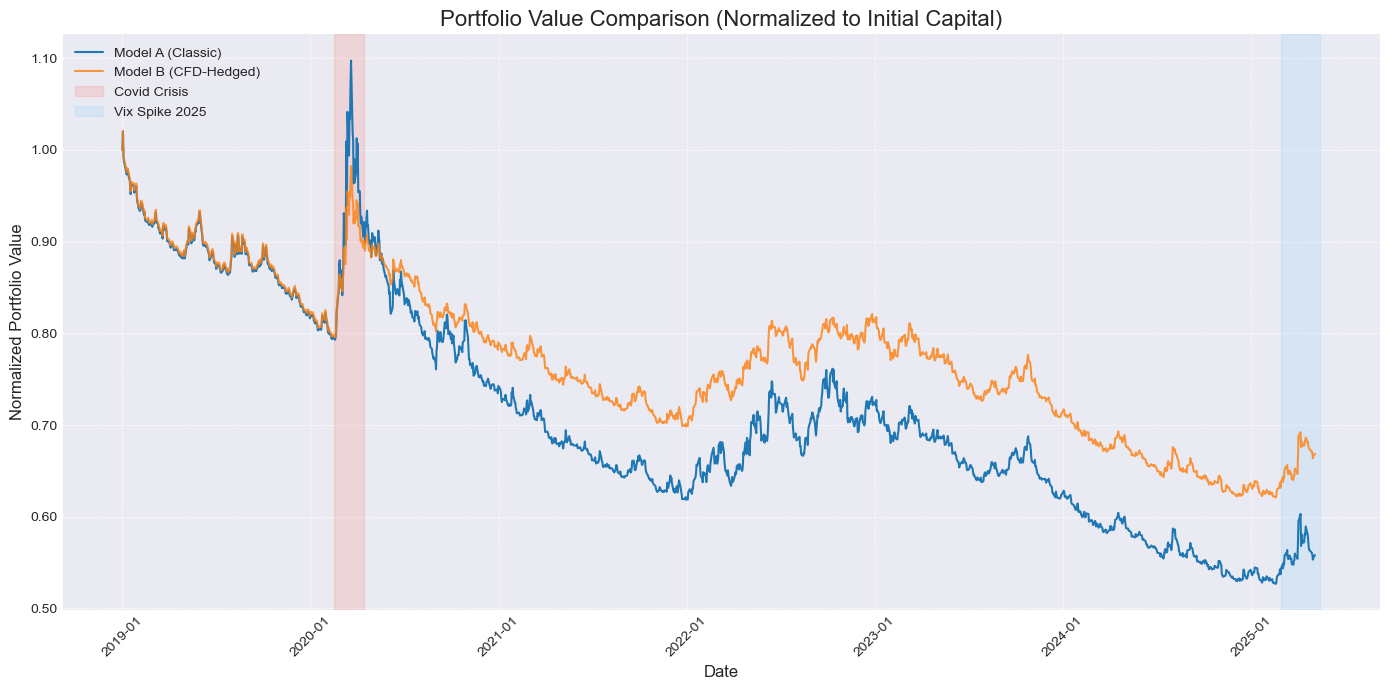

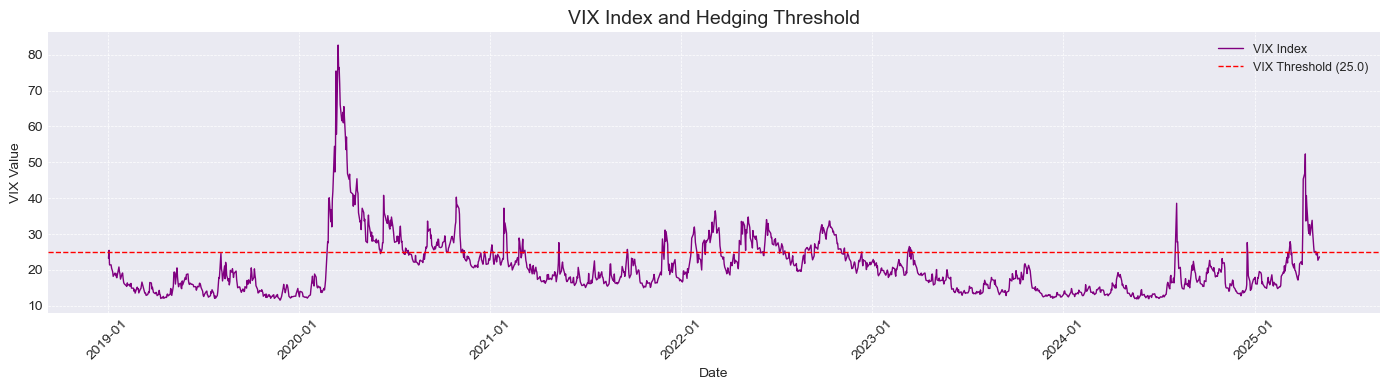

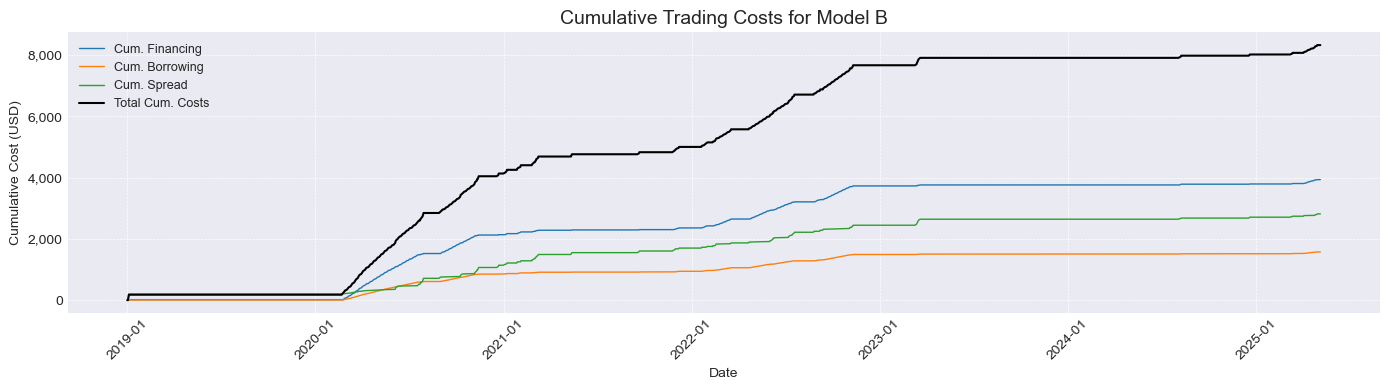

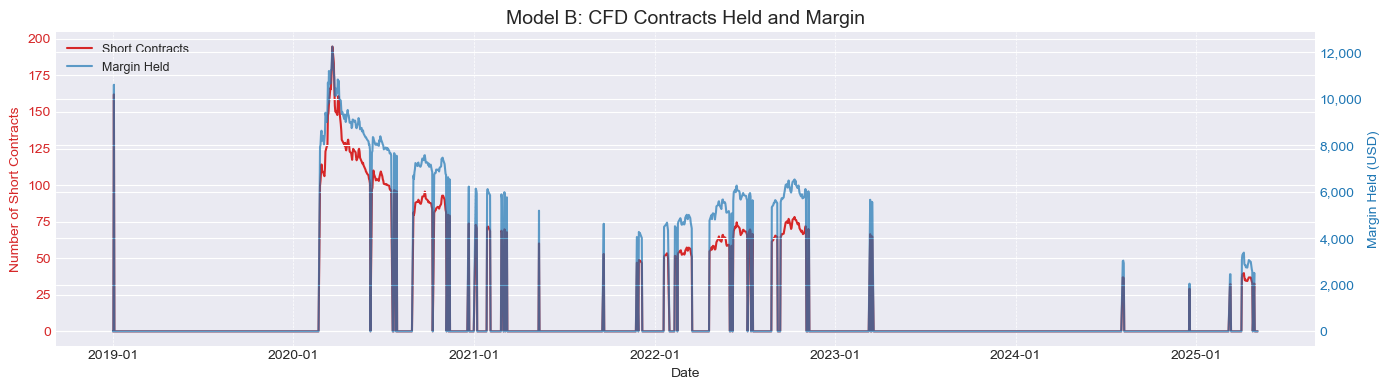


--- Notebook Cell Execution for Plots Complete ---


In [25]:
# ==============================================================================
# Step 5: Generate and Show/Save Plots
# ==============================================================================
print("\n[Step 5/5] Generating Plots...")
overall_start_time = time.time() # Placeholder, true start time would be before cell 1

if sim_portfolio_A is not None and not sim_portfolio_A.empty and \
   sim_portfolio_B is not None and not sim_portfolio_B.empty and \
   main_df is not None and not main_df.empty:
    try:
        fig_comp = plot_portfolio_comparison_notebook(sim_portfolio_A, sim_portfolio_B, config)
        save_plot_notebook(fig_comp, "portfolio_comparison.png", config)

        fig_vix_plot = plot_vix_notebook(main_df, config)
        save_plot_notebook(fig_vix_plot, "vix_threshold.png", config)

        if sim_cost_df is not None and not sim_cost_df.empty:
            fig_costs_plot = plot_costs_notebook(sim_cost_df)
            save_plot_notebook(fig_costs_plot, "cumulative_costs.png", config)
            fig_contracts_plot = plot_contracts_margin_notebook(sim_cost_df)
            save_plot_notebook(fig_contracts_plot, "contracts_margin.png", config)
        else:
            print("Cost data (sim_cost_df) is empty, skipping related plots.")
        
        if config['plotting']['show_plots_inline']: plt.show()
        else: plt.close('all'); print("Plots saved (if enabled). Figures closed.")
            
    except Exception as e_plot:
        print(f"ERROR: Plot generation failed. {e_plot}")
        import traceback; traceback.print_exc()
else:
    print("Skipping plot generation (empty simulation results or failed data loading).")
        
overall_end_time = time.time() # This will only time this cell if not careful
# print(f"\n--- Plotting Finished in {overall_end_time - overall_start_time:.2f} seconds ---") # Timing is a bit off here
print(f"\n--- Notebook Cell Execution for Plots Complete ---")

---
## End of Notebook
---